| Authors:  | Bex Dunn|
|----------|----------------|
| Created: | Feb 20, 2019 |
| Last edited: | Feb 20, 2019 |

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

__Background:__ Data from the [Landsat](https://landsat.usgs.gov/about-landsat) 5,7 and 8 satellite missions are accessible through [Digital Earth Australia](http://www.ga.gov.au/about/projects/geographic/digital-earth-australia) (DEA). 

The *Tasseled Cap Index (TCI)* is a method of reducing 6 bands of satellite data (BLUE, GREEN, RED, NIR, SWIR1, SWIR2) to 3 bands (Brightness, Greenness, Wetness) using a Principal Components Analysis and Procrustes' Rotation [(Roberts et al 2018)](##References). This notebook uses the published coefficients of [Crist 1985](##References) as applied to Digital Earth Australia's Landsat satellite data.This notebook produces the wetness index.

__What does this notebook do?:__ This notebook takes a supplied shapefile of a polygon and queries the datacube Landsat surface reflectance data. It calculates thresholded tasselled cap wetness. The results are output as geotiff.

In [1]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff

sys.path.append('../10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

In [2]:
#change the path here if you want a different polygon
#poly_path = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/reeves_lake_for_demo.shp'
#poly_path = '/g/data/r78/rjd547/shapefiles/EnvironmentalFlowMonitoringPolygon.shp'
poly_path = '/g/data/r78/rjd547/shapefiles/FarmScaleWaterBalancePolygon.shp'

In [3]:
#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

<Figure size 432x288 with 0 Axes>

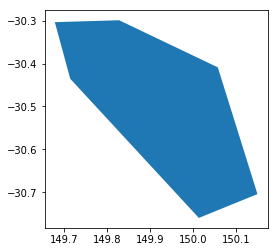

In [4]:
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()
plt.show()

In [5]:
query = {'geopolygon': geom,
         #'time': ('2018-05-01', '2018-07-31')
         'time': ('2016-10-01', '2017-04-30')
         }

## Set up datasets

### set cloudmasking threshold and load landsat nbart data

In [6]:
#set cloudmasking threshold and load landsat nbart data
landsat_masked_prop = 0 # 0.90
ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart', 
                mask_dict=dict(cloud_acca='no_cloud',
                 cloud_shadow_acca='no_cloud_shadow',
                 cloud_shadow_fmask='no_cloud_shadow',
                 cloud_fmask='no_cloud',
                 blue_saturated=False,
                 green_saturated=False,
                 red_saturated=False,
                 nir_saturated=False,
                 swir1_saturated=False,
                 swir2_saturated=False,
                 contiguous=True),
                mask_pixel_quality=True,
                masked_prop=landsat_masked_prop)

Loading ls5 pixel quality
    Skipping ls5; no valid data for query
Ignoring SLC-off observations for ls7
Loading ls7 pixel quality
    Loading 0 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 27 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### mask the data with our original polygon to remove extra data 

In [7]:
data = ls578_ds
mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=False)

In [8]:
#for some reason xarray is not playing nicely with our old masking function
mask_xr = xr.DataArray(mask, dims = ('y','x'))
ls578_ds = data.where(mask_xr==False)

In [9]:
# plt.clf()
# DEAPlotting.rgb(ls578_ds, bands=['swir1', 'nir', 'green'], col='time',col_wrap=4)
# plt.show()

In [10]:
#transform the nbart into tci
tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-1200, drop=True , drop_tc_bands=False)

In [11]:
tcw = tci['wetness']

## Write geotiffs of wetness for each time we have imagery

In [12]:
#get attrs off our original dataset
tcw_dataset=tcw.to_dataset()
tcw_dataset.attrs=ls578_ds.attrs

### set up paths to write out outputs to

In [13]:
#get polygon name from the polygon path
polyname = poly_path.split('/')[-1].split('.')[0]

In [14]:
savefilepath = '/g/data/r78/rjd547/WaterCompHackFeb2019/'+polyname

In [15]:
#set dataset equal to wetness dataset
ds = tcw_dataset
#write a geotiff to file for each timestep
if len(ds.time)==1:
    print('one timestep')
    #drop the time dimension for only one timestep
    #write the dataset without the data percentage to file
    ds1 = ds.squeeze()
    #ds1 = ds1.drop('data_perc')
    write_geotiff(savefilepath+'_TCW_'+'.tif', ds1)

elif len(ds.time)>1:
    print('multiple timesteps') 
    #remove data percentage as it breaks the geotiff writer
    #ds = ds.drop('data_perc')
    for timestep in range(len(ds.time)):
        timestep_date =np.datetime_as_string(ds.time.isel(time=timestep))[0:10]
        try:
            write_geotiff(savefilepath+'_TCW_'+timestep_date+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

multiple timesteps
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF


## Write geotiffs of thresholded wetness for each time we have imagery

In [16]:
#get attrs off our original dataset
tcw_thresholded = tci['wetness_thresholded']
tcw_thresholded_dataset=tcw_thresholded.to_dataset()
tcw_thresholded_dataset.attrs=ls578_ds.attrs

### NB threshold here is hardcoded into filename

In [17]:
#set dataset equal to thresholded wetness dataset
ds = tcw_thresholded_dataset
#write a geotiff to file for each timestep
if len(ds.time)==1:
    print('one timestep')
    #drop the time dimension for only one timestep
    #write the dataset without the data percentage to file
    ds1 = ds.squeeze()
    #ds1 = ds1.drop('data_perc')
    write_geotiff(savefilepath+'_TCW-1200_'+'.tif', ds1)

elif len(ds.time)>1:
    print('multiple timesteps') 
    #remove data percentage as it breaks the geotiff writer
    #ds = ds.drop('data_perc')
    for timestep in range(len(ds.time)):
        timestep_date =np.datetime_as_string(ds.time.isel(time=timestep))[0:10]
        try:
            write_geotiff(savefilepath+'_TCW-1200_'+timestep_date+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

multiple timesteps
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF


## Write geotiffs of surface reflectance for each time we have imagery

In [18]:
for timestep in range(len(ds.time)):
    print(np.datetime_as_string(ds.time.isel(time=timestep))[0:10])

2016-10-03
2016-10-10
2016-10-19
2016-10-26
2016-11-04
2016-11-11
2016-11-20
2016-11-27
2016-12-06
2016-12-13
2016-12-22
2016-12-29
2017-01-07
2017-01-14
2017-01-23
2017-01-30
2017-02-08
2017-02-15
2017-02-24
2017-03-03
2017-03-12
2017-03-19
2017-03-28
2017-04-04
2017-04-13
2017-04-20
2017-04-29


In [19]:
#set dataset equal to landsat dataset
ds = ls578_ds
#write a geotiff to file for each timestep
if len(ds.time)==1:
    print('one timestep')
    #drop the time dimension for only one timestep
    #write the dataset without the data percentage to file
    ds1 = ds.squeeze()
    #ds1 = ds1.drop('data_perc')
    write_geotiff(savefilepath+'_LS_'+'.tif', ds1)

elif len(ds.time)>1:
    print('multiple timesteps') 
    #remove data percentage as it breaks the geotiff writer
    #ds = ds.drop('data_perc')
    for timestep in range(len(ds.time)):
        timestep_date =np.datetime_as_string(ds.time.isel(time=timestep))[0:10]
        try:
            write_geotiff(savefilepath+'_LS_'+timestep_date+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

multiple timesteps
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF


## References

1. Roberts, D., Dunn,B., Mueller, N. 2018, *Open Data Cube Products Using High-Dimensional Statistics of Time Series*, in press.

2. E. P. Crist, *A tm tasseled cap equivalent transformation for reflectance
factor data*, Remote Sensing of Environment, vol. 17, no. 3, pp. 301-306, 1985.